# Advanced Lane Finding 

The goal of this project is to make a pipeline to process a video stream from camera which mounted on the front of c car, and output an annotated video which includes the below features:

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## Step 1: Distortion Correction

Firstly I will use cv2.findChessboardCorners() and cv2.drawChessboardCorners() to find and draw the inside corners in those chessboards.

In [148]:
CAL_IMGS_PATH = 'camera_cal/calibration*.jpg'
TEST_IMGS_PATH = 'test_images/test*.jpg'

class Calibration:
    perspective_src = np.float32([[490, 482],[810, 482],
                                  [1250, 720],[40, 720]])
    perspective_dst = np.float32([[0, 0], [1280, 0],
                                  [1250, 720],[40, 720]])

    def __init__(self, nx, ny):
        # nx represent the number of inside corners in x axis
        # ny represent the number of inside corners in y axis
        self.nx, self.ny = nx, ny
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane
        self.cal_imgs = []
        self.cal_imgs_with_corners = []
        self.test_imgs = []
        self.test_imgs_with_undistorted = []
        self.test_imgs_with_birdseye = []
        # perspective transform matrix
        self.M = cv2.getPerspectiveTransform(self.perspective_src, self.perspective_dst)
        # inverse perspective matrix
        self.Minv = cv2.getPerspectiveTransform(self.perspective_dst, self.perspective_src)

    def get_objpoints(self):
        return self.objpoints

    def get_imgpoints(self):
        return self.imgpoints

    def get_perspective_matrix(self):
        return self.M

    def get_interse_perspective_matrix(self):
        return self.Minv

    def load_cal_imgs(self, cal_path):
        cal_img_names = glob.glob(cal_path)
        self.cal_imgs = [cv2.imread(name) for name in cal_img_names]

    def load_test_imgs(self, test_path):
        test_img_names = glob.glob(test_path)
        self.test_imgs = [cv2.imread(name) for name in test_img_names]

    def draw_corners(self):
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        for img in self.cal_imgs:
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            # If found, draw corners
            if ret == True:
                orig_img = img.copy()
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw the corners
                cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                self.cal_imgs_with_corners.append(((orig_img, img)))

    def undistort(self):
        for img in self.test_imgs:
            img_size = (img.shape[1], img.shape[0])
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
            undist = cv2.undistort(img, mtx, dist, None, mtx)
            self.test_imgs_with_undistorted.append((img, undist))

    def birds_eye(self):
        for orig_img, undist_img in self.test_imgs_with_undistorted:
            # Grab the image shape
            img_size = (orig_img.shape[1], orig_img.shape[0])
            # Warp the image using OpenCV warpPerspective()
            warped = cv2.warpPerspective(undist_img, self.M, img_size)
            self.test_imgs_with_birdseye.append((orig_img, warped))

    def combined_binary(self):
        
        combined_binary_lst = []
        for _, img in self.test_imgs_with_birdseye:
            l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
            b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]

            b_thresh_min = 145
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

            l_thresh_min = 200
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(img[:, :, 0])
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

            combined_binary_lst.append(combined_binary)

        return combined_binary_lst

    def fill_lane(self):
        for i, imgs in enumerate(self.test_imgs_with_undistorted):
            _, undist_img = imgs
            binary_warped = self.combined_binary()[i]

            # Create an image to draw the lines on
            warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
            color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            print(type(leftx))
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Calculate the position of the vehicle
            y_max = binary_warped.shape[0]
            rightx_int = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
            leftx_int = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
            center = abs(640 - ((rightx_int+leftx_int)/2))

            # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, self.Minv, (binary_warped.shape[1], binary_warped.shape[0]))
            # Combine the result with the original image
            result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)

            # Measure Radius of Curvature for each lane line
            ym_per_pix = 30./720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meteres per pixel in x dimension
            left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
            right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                    /np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                    /np.absolute(2*right_fit_cr[0])

            # plot
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            ax2.set_title('Fill Lane Between Polynomials', fontsize=18)
            if center < 640:
                ax2.text(200, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
                         style='italic', color='white', fontsize=10)
            else:
                ax2.text(200, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
                         style='italic', color='white', fontsize=10)
            ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),
                     style='italic', color='white', fontsize=10)

    def show_cal_plot(self):
        for orig_img, img in self.cal_imgs_with_corners:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(orig_img)
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(img)
            ax2.set_title('Image With Corners', fontsize=18)

    def show_test_plot(self):
        for orig_img, img in self.test_imgs_with_undistorted:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Undistorted Image', fontsize=18)

    def show_birdseye_plot(self):
        for orig_img, img in self.test_imgs_with_birdseye:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
            ax1.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('Warped Image', fontsize=18)

    def show_threshold_plot(self):

        for _, img in self.test_imgs_with_birdseye:
    
            l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]   
            b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
            
            b_thresh_min = 155
            b_thresh_max = 200
            b_binary = np.zeros_like(b_channel)
            b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

            l_thresh_min = 235
            l_thresh_max = 255
            l_binary = np.zeros_like(l_channel)
            l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

            combined_binary = np.zeros_like(img[:, :, 0])
            combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

            # Plotting thresholded images
            f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='col', sharex='row', figsize=(10,6))
            f.tight_layout()

            ax1.set_title('Warped Image', fontsize=16)
            ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

            ax2.set_title('b binary threshold', fontsize=16)
            ax2.imshow(b_binary, cmap='gray')

            ax3.set_title('l binary threshold', fontsize=16)
            ax3.imshow(l_binary, cmap='gray')

            ax4.set_title('Combined color thresholds', fontsize=16)
            ax4.imshow(combined_binary, cmap='gray')

In [143]:
# find and draw the inside corner of the chessboards 
cal = Calibration(9, 6)
cal.load_cal_imgs(CAL_IMGS_PATH)
cal.draw_corners()
# cal.show_cal_plot()

Next I will use undistort() to calculate camera calibration matrix and distortion coefficients. It can remove distortion of image and output the undistorted image.

In [144]:
# undistort the test images
cal.load_test_imgs(TEST_IMGS_PATH)
cal.undistort()
# cal.show_test_plot()

## Step 2: Perspective Transform

In [145]:
cal.birds_eye()
#cal.show_birdseye_plot()

## Step 3: Apply Binary Thresholds

In [146]:
# cal.show_threshold_plot()

## Steps 4, 5 and 6: Fitting a polynomial to the lane lines, calculating vehicle position and radius of curvature:

<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------
<class 'numpy.ndarray'>
---------


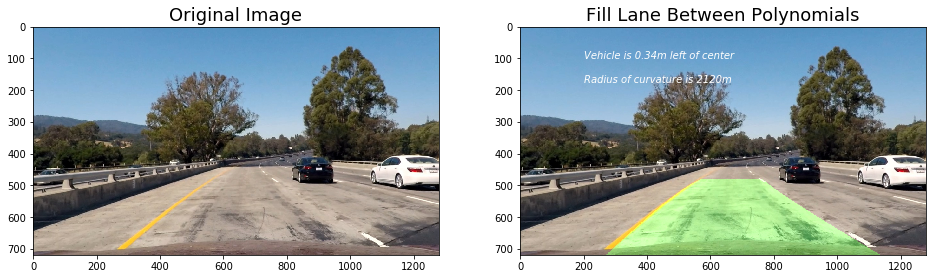

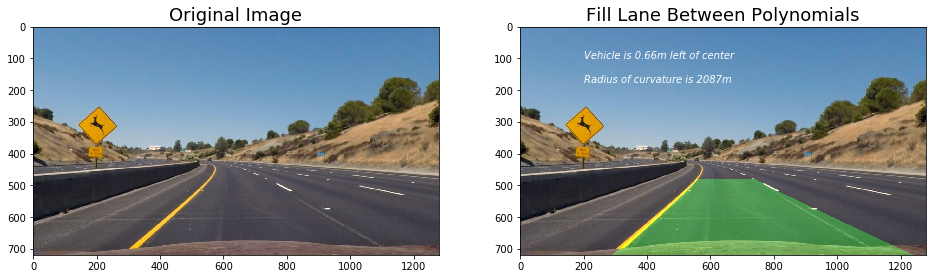

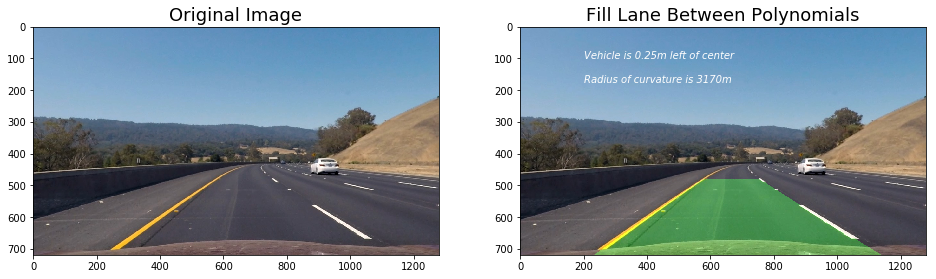

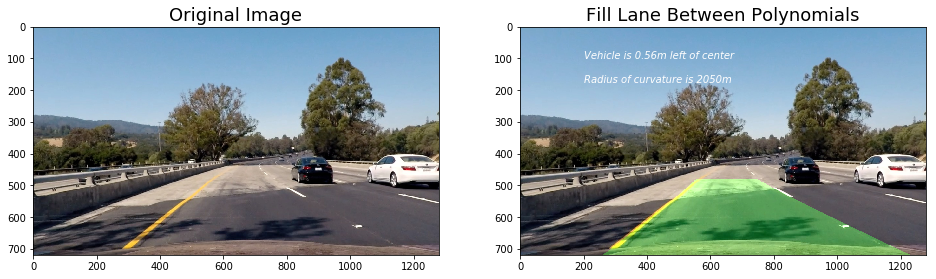

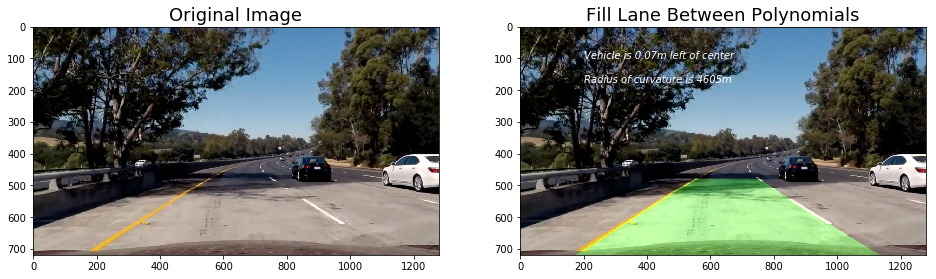

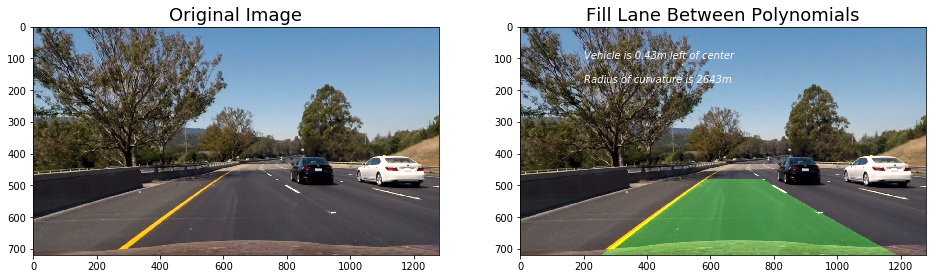

In [147]:
cal.fill_lane()

## Video Processing Pipeline:

In [209]:
class Lane:
    def __init__(self):
        # was the line found in the last iteration?
        self.found = False
        # Set the width of the windows +/- margin
        self.margin = 100
        # Set minimum number of pixels found to recenter window
        self.minpix = 50
        # Choose the number of sliding windows
        self.nwindows = 9
        
        # Store recent polynomial coefficients for averaging across frames
        self.left_fit0 = deque(maxlen=10)
        self.left_fit1 = deque(maxlen=10)
        self.left_fit2 = deque(maxlen=10)
        self.right_fit0 = deque(maxlen=10)
        self.right_fit1 = deque(maxlen=10)
        self.right_fit2 = deque(maxlen=10)
        

        # left fit coefficient
        self.left_fit = np.array([])
        # right fit coefficient
        self.right_fit = np.array([])
        
        # Count the number of frames
        self.count = 0
        
        # radius of left and right lane
        self.left_radius, self.right_radius = 0, 0
        
    def append_fit(self, left_fit, right_fit):
        self.left_fit0.append(left_fit[0])
        self.left_fit1.append(left_fit[1])
        self.left_fit2.append(left_fit[2])
        self.right_fit0.append(right_fit[0])
        self.right_fit1.append(right_fit[1])
        self.right_fit2.append(right_fit[2])

    def smooth_fit(self):
        left_fit = [np.mean(self.left_fit0), np.mean(self.left_fit1), np.mean(self.left_fit2)]
        right_fit = [np.mean(self.right_fit0), np.mean(self.right_fit1), np.mean(self.right_fit2)]
        return left_fit, right_fit 
        
    def set_radius(self, left_radius, right_radius):
        self.left_radius = left_radius
        self.right_radius = right_radius
        
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad

    def found_search(self, img):
        # "img" is a warped binary image from the next frame of video
        # It's now much easier to find line pixels!
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = []
        right_lane_inds = []

        left_lane_inds = ((nonzerox > (np.mean(self.left_fit0)*(nonzeroy**2) + np.mean(self.left_fit1)*nonzeroy +
                                       np.mean(self.left_fit2) - margin)) & (nonzerox < (np.mean(self.left_fit0)*(nonzeroy**2) +
                                                                                  np.mean(self.left_fit1)*nonzeroy + np.mean(self.left_fit2) + margin)))

        right_lane_inds = ((nonzerox > (np.mean(self.right_fit0)*(nonzeroy**2) + np.mean(self.right_fit1)*nonzeroy +
                                        np.mean(self.right_fit2) - margin)) & (nonzerox < (np.mean(self.right_fit0)*(nonzeroy**2) +
                                                                                    np.mean(self.right_fit1)*nonzeroy + np.mean(self.right_fit2) + margin)))


        if  len(left_lane_inds) > 0 and  len(right_lane_inds) > 0:
            self.found = True
            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
        else:
            self.found = False
            leftx, lefty, rightx, righty = None, None, None, None

        return leftx, lefty, rightx, righty

    def blind_search(self, img):
        # "img" is a warped binary image
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0]//2:, :], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(img.shape[0]/self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

#         if (not left_lane_inds) and (not right_lane_inds):
        if  len(left_lane_inds) > 0 and  len(right_lane_inds) > 0:
            self.found = True
            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
        else:
            self.found = False
            leftx, lefty, rightx, righty = None, None, None, None

        return leftx, lefty, rightx, righty

In [210]:
OBJPOINTS = cal.get_objpoints()
IMGPOINTS = cal.get_imgpoints()
M = cal.get_perspective_matrix()
MINV = cal.get_interse_perspective_matrix()


def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(OBJPOINTS, IMGPOINTS, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def birds_eye(img):          
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    return warped

def combined_binary(img):
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]

    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(img[:, :, 0])
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
#     _, (ax1) = plt.subplots(1, 1, figsize=(16,8))
# #     ax1.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
#     ax1.imshow(b_binary, cmap='gray')

    return combined_binary

def pipeline(img_rgb):    
    
    # convert rgb to bgr
    img = img_rgb[..., ::-1]
    undist_img = undistort(img)
    warped_img = birds_eye(undist_img) 
    binary_warped = combined_binary(warped_img)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    if not lane.found:
        leftx, lefty, rightx, righty = lane.blind_search(binary_warped)
    else:
        leftx, lefty, rightx, righty = lane.found_search(binary_warped)
    
    # Fit a second order polynomial to each
    left_fit_tmp = np.polyfit(lefty, leftx, 2)
    right_fit_tmp = np.polyfit(righty, rightx, 2)

    
    lane.append_fit(left_fit_tmp, right_fit_tmp)
    # Smooth lane through calculate the fit of average
    left_fit, right_fit = lane.smooth_fit()
    
    # save left and right fit coefficient
#     lane.save_fit(left_fit, right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Calculate the position of the vehicle
    y_max = binary_warped.shape[0]
    rightx_int = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    leftx_int = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MINV, (binary_warped.shape[1], binary_warped.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    # convert bgr to rgb
    result_rgb = result[..., ::-1]
     
    # Compute radius of curvature for each lane in meters
    left_curverad = lane.radius_of_curvature(leftx, lefty)
    right_curverad = lane.radius_of_curvature(rightx, righty)
    
    # Only print the radius of curvature every 3 frames for improved readability
    if lane.count % 3 == 0:
        lane.set_radius(left_curverad, right_curverad)
    
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((lane.left_radius+lane.right_radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    lane.count += 1

    return result_rgb

In [211]:
# for name in glob.glob('test_images/test*.jpg'):
#     img = mpimg.imread(name)
#     pipeline(img)

In [216]:
lane = Lane()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(1,2)
# clip1 = VideoFileClip("project_video.mp4").subclip(41, 42)
white_clip = clip1.fl_image(pipeline) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4



 96%|█████████▌| 25/26 [00:32<00:01,  1.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [217]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

In [26]:
# video_output = 'challenge_result.mp4'
# clip1 = VideoFileClip("challenge_video.mp4")
# white_clip = clip1.fl_image(pipeline) 
# white_clip.write_videofile(video_output, audio=False)

In [13]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))